<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/MSFTRolling_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

     |████████████████████████████████| 6.3MB 4.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=cc1041226ff0c5f018440d049ac5ff2a33d1d939adf141bb73fa2711cd1b42eb
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=c6597f9f5229888f4cb42159763af892f72464cd416fee3c8622e0e1b1ed9cad
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns 

import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns

In [4]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "MSFT",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

df['Date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment

df['hour_id'] = df[df.columns[-2:]].apply(
    lambda x: '.'.join(x.dropna().astype(str)),
    axis=1
)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()


[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Date,datehour,hour_id,Next_close
1759,2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,2020-12-31,11,2020-12-31.11,220.285004
1760,2020-12-31 12:30:00-05:00,219.914993,220.406494,219.800003,220.285004,220.285004,1172462,2020-12-31,12,2020-12-31.12,220.559998
1761,2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,2020-12-31,13,2020-12-31.13,221.369995
1762,2020-12-31 14:30:00-05:00,220.559998,221.630005,220.529999,221.369995,221.369995,1800116,2020-12-31,14,2020-12-31.14,222.449997
1763,2020-12-31 15:30:00-05:00,221.369995,223.000000,221.160095,222.449997,222.449997,3623446,2020-12-31,15,2020-12-31.15,NaN


In [5]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [6]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')
df

,Open,High,Low,Close,Adj Close,Volume,Date,datehour,hour_id,Next_close,SMA,EMA,obv
Datetime,,,,,,,,,,,,,
2020-01-02 09:30:00-05:00,158.779999,159.554993,158.330002,159.100006,159.100006,5598544,2020-01-02,9,2020-01-02.9,159.485001,159.100006,159.100006,0.0
2020-01-02 10:30:00-05:00,159.095001,159.630005,158.990005,159.485001,159.485001,2349407,2020-01-02,10,2020-01-02.10,159.529999,159.292503,159.138506,2349407.0
2020-01-02 11:30:00-05:00,159.479996,159.619995,159.110001,159.529999,159.529999,1784440,2020-01-02,11,2020-01-02.11,159.615005,159.371668,159.177655,4133847.0
2020-01-02 12:30:00-05:00,159.520004,159.800003,159.445007,159.615005,159.615005,1571495,2020-01-02,12,2020-01-02.12,159.934998,159.543335,159.221390,5705342.0
2020-01-02 13:30:00-05:00,159.615005,159.949997,159.529999,159.934998,159.934998,1508504,2020-01-02,13,2020-01-02.13,160.070007,159.693334,159.292751,7213846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 11:30:00-05:00,220.274994,220.460007,219.679993,219.910004,219.910004,2132707,2020-12-31,11,2020-12-31.11,220.285004,220.563334,222.495879,357081786.0
2020-12-31 12:30:00-05:00,219.914993,220.406494,219.800003,220.285004,220.285004,1172462,2020-12-31,12,2020-12-31.12,220.559998,220.158335,222.274791,358254248.0
2020-12-31 13:30:00-05:00,220.286896,220.600006,219.880005,220.559998,220.559998,1402907,2020-12-31,13,2020-12-31.13,221.369995,220.251668,222.103312,359657155.0


In [7]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1380389d0>,
      dtype=object)

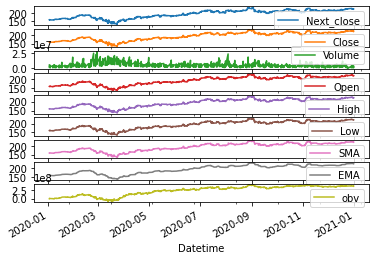

In [8]:
df.plot(subplots=True)


In [9]:
# Start trialling local linear regression

import numpy as np
import statsmodels.api as sm
dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)


X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
pip install pyfinance

     |████████████████████████████████| 61kB 2.4MB/s 


In [11]:
import pyfinance

In [12]:
from pyfinance import ols
import pandas_datareader as pdr
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn

rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end  subperiod           
129  0           0.256320
     1           0.259166
     2           0.259674
     3           0.260378
     4           0.263241
...                   ...
1762 1758        0.876935
     1759        0.873015
     1760        0.877447
     1761        0.879673
     1762        0.889141

[212420 rows x 1 columns]

In [13]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts

In [14]:
y_pred = y_pred.reset_index()

In [15]:
y_pred

,subperiod,end,predicted
0,0,129,0.256320
1,1,259,0.259145
2,2,390,0.259688
3,3,522,0.260389
4,4,655,0.263237
...,...,...,...
1758,1758,8800,0.876492
1759,1759,7042,0.872508
1760,1760,5283,0.876840
1761,1761,3523,0.879378


In [16]:
y = y.reset_index()
y = y.rename(columns={'index':'period', 0:'actual'})
y

,period,actual
0,0,0.258069
1,1,0.258528
2,2,0.259393
3,3,0.262651
4,4,0.264026
...,...,...
1758,1758,0.873333
1759,1759,0.877151
1760,1760,0.879951
1761,1761,0.888199


In [17]:
linear = y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['rt_sq_er'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,rt_sq_er
0,0.258069,0.256320,0.001749,3.060512e-06,0.001749
1,0.258528,0.259145,-0.000617,3.806219e-07,0.000617
2,0.259393,0.259688,-0.000295,8.675708e-08,0.000295
3,0.262651,0.260389,0.002262,5.116920e-06,0.002262
4,0.264026,0.263237,0.000789,6.228427e-07,0.000789
...,...,...,...,...,...
1758,0.873333,0.876492,-0.003160,9.984168e-06,0.003160
1759,0.877151,0.872508,0.004643,2.155937e-05,0.004643
1760,0.879951,0.876840,0.003111,9.681354e-06,0.003111
1761,0.888199,0.879378,0.008821,7.780363e-05,0.008821


In [18]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.015365607474902353

Text(0.5, 0.98, 'Root Mean Squared Error Distribution')

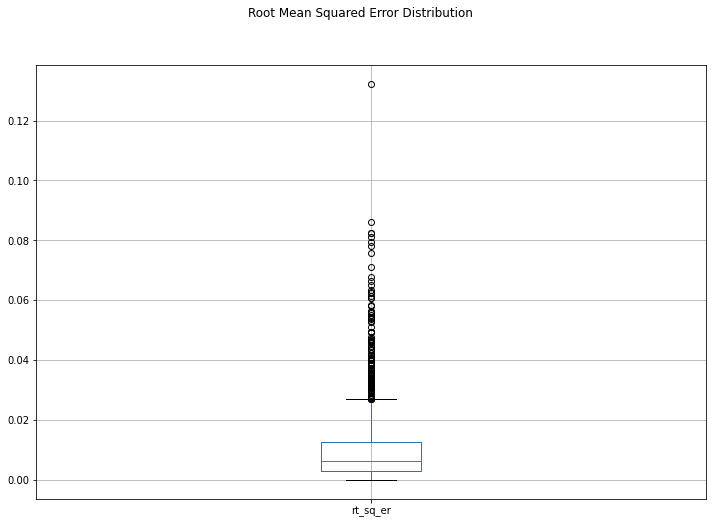

In [19]:
boxplot = linear.boxplot(column=['rt_sq_er'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution')

## With sentiment

In [21]:
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df['date'].map(str) + '.' + df['datehour'].map(str) 
df['hour_id']
sent = pd.read_csv('MSFT_sentiment_hr.csv')
df = pd.merge(df, sent, on = 'hour_id', how='left')
df = df.fillna(0)
df.describe()

,index,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,datehour,Unnamed: 0,compound,Count,average
count,1764.000000,1764.000000,1764.000000,1.764000e+03,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1.764000e+03,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,881.500000,192.850859,192.941052,4.566292e+06,192.923205,193.826058,191.999467,192.905380,192.619766,2.331774e+08,11.994898,3325.650794,0.274432,13.811791,0.036698
std,509.367255,23.380902,22.939246,3.129898e+06,22.959028,22.785486,23.090558,22.918618,22.752311,1.350495e+08,2.000702,2383.019404,1.860808,27.859602,0.211690
min,0.000000,0.000000,134.139999,0.000000e+00,134.160004,137.250000,132.520004,135.313334,139.093149,-7.974553e+07,9.000000,0.000000,-17.594100,0.000000,-0.845500
25%,440.750000,173.799923,173.799923,2.562148e+06,173.881248,174.474998,172.899994,173.581750,173.271001,1.191854e+08,10.000000,1123.750000,-0.337300,2.000000,-0.039418
50%,881.500000,200.931046,200.931046,3.564974e+06,200.864998,201.840004,199.910004,201.257484,201.059177,2.833942e+08,12.000000,3278.500000,0.000000,5.000000,0.000000
75%,1322.250000,212.397499,212.397499,5.511006e+06,212.389999,213.184994,211.602505,212.350416,212.242562,3.474824e+08,14.000000,5369.250000,0.823400,13.000000,0.114931
max,1763.000000,232.350006,232.350006,2.795370e+07,232.354996,232.860001,231.350006,232.180003,228.858003,4.074811e+08,15.000000,7563.000000,22.077400,337.000000,0.955900


In [22]:
df

,index,Datetime,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,date,datehour,hour_id,Unnamed: 0,compound,Count,average
0,0,2020-01-02 09:30:00-05:00,159.485001,159.100006,5598544,158.779999,159.554993,158.330002,159.100006,159.100006,0.0,2020-01-02,9,2020-01-02.9,0.0,0.0000,0.0,0.0000
1,1,2020-01-02 10:30:00-05:00,159.529999,159.485001,2349407,159.095001,159.630005,158.990005,159.292503,159.138506,2349407.0,2020-01-02,10,2020-01-02.10,8.0,0.5106,2.0,0.2553
2,2,2020-01-02 11:30:00-05:00,159.615005,159.529999,1784440,159.479996,159.619995,159.110001,159.371668,159.177655,4133847.0,2020-01-02,11,2020-01-02.11,9.0,0.0000,1.0,0.0000
3,3,2020-01-02 12:30:00-05:00,159.934998,159.615005,1571495,159.520004,159.800003,159.445007,159.543335,159.221390,5705342.0,2020-01-02,12,2020-01-02.12,10.0,0.5267,1.0,0.5267
4,4,2020-01-02 13:30:00-05:00,160.070007,159.934998,1508504,159.615005,159.949997,159.529999,159.693334,159.292751,7213846.0,2020-01-02,13,2020-01-02.13,11.0,1.6208,2.0,0.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,1759,2020-12-31 11:30:00-05:00,220.285004,219.910004,2132707,220.274994,220.460007,219.679993,220.563334,222.495879,357081786.0,2020-12-31,11,2020-12-31.11,7546.0,0.0000,1.0,0.0000
1760,1760,2020-12-31 12:30:00-05:00,220.559998,220.285004,1172462,219.914993,220.406494,219.800003,220.158335,222.274791,358254248.0,2020-12-31,12,2020-12-31.12,0.0,0.0000,0.0,0.0000
1761,1761,2020-12-31 13:30:00-05:00,221.369995,220.559998,1402907,220.286896,220.600006,219.880005,220.251668,222.103312,359657155.0,2020-12-31,13,2020-12-31.13,7547.0,0.7579,1.0,0.7579
1762,1762,2020-12-31 14:30:00-05:00,222.449997,221.369995,1800116,220.559998,221.630005,220.529999,220.738332,222.029980,361457271.0,2020-12-31,14,2020-12-31.14,7548.0,0.0000,2.0,0.0000


In [23]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)


X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent

predicted
end  subperiod           
129  0           0.685702
     1           0.686953
     2           0.687063
     3           0.687535
     4           0.688841
...                   ...
1762 1758        0.947679
     1759        0.946421
     1760        0.948290
     1761        0.948773
     1762        0.953227

[212420 rows x 1 columns]

In [24]:
y_pred_sent = y_pred_sent.reset_index()
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [25]:
linear_sent = y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,actual,end,predicted,predicted_sent
0,0.686400,129,0.685702,0.685702
1,0.686593,259,1.373887,0.686944
2,0.686959,390,2.061205,0.687068
3,0.688337,522,2.750100,0.687525
4,0.688918,655,3.444062,0.688812
...,...,...,...,...
1758,0.946460,8800,4.737171,0.947434
1759,0.948074,7042,3.784848,0.946212
1760,0.949258,5283,2.844099,0.948033
1761,0.952744,3523,1.897354,0.948677


In [26]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted','end'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['rt_sq_er_sent'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,actual,predicted_sent,difference_sent,sq_er_sent,rt_sq_er_sent
0,0.686400,0.685702,0.000698,4.866732e-07,0.000698
1,0.686593,0.686944,-0.000350,1.225254e-07,0.000350
2,0.686959,0.687068,-0.000109,1.185619e-08,0.000109
3,0.688337,0.687525,0.000811,6.585112e-07,0.000811
4,0.688918,0.688812,0.000105,1.108151e-08,0.000105
...,...,...,...,...,...
1758,0.946460,0.947434,-0.000974,9.487920e-07,0.000974
1759,0.948074,0.946212,0.001862,3.466768e-06,0.001862
1760,0.949258,0.948033,0.001224,1.499276e-06,0.001224
1761,0.952744,0.948677,0.004067,1.653761e-05,0.004067


In [27]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.006470365661142606

Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

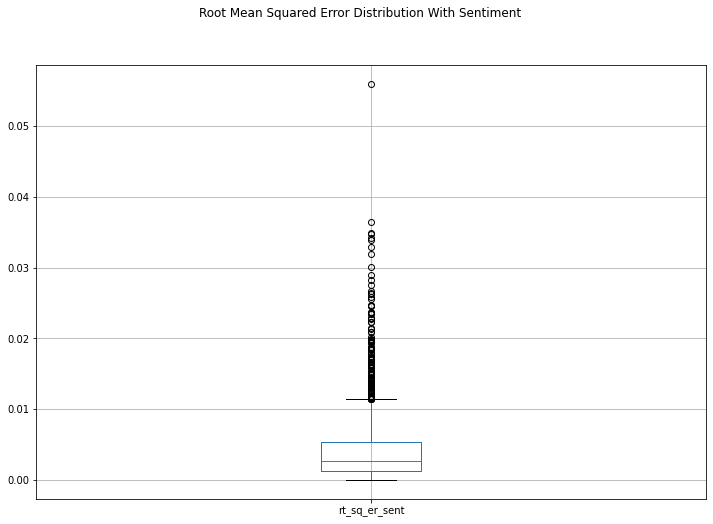

In [28]:
boxplot = linear_sent.boxplot(column=['rt_sq_er_sent'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [29]:
linear = linear.reset_index()
linear_sent = linear_sent.reset_index()
MSFT_linear = pd.merge(linear, linear_sent, on = 'index')
MSFT_linear

,index,actual_x,predicted,difference,sq_er,rt_sq_er,actual_y,predicted_sent,difference_sent,sq_er_sent,rt_sq_er_sent
0,0,0.258069,0.256320,0.001749,3.060512e-06,0.001749,0.686400,0.685702,0.000698,4.866732e-07,0.000698
1,1,0.258528,0.259145,-0.000617,3.806219e-07,0.000617,0.686593,0.686944,-0.000350,1.225254e-07,0.000350
2,2,0.259393,0.259688,-0.000295,8.675708e-08,0.000295,0.686959,0.687068,-0.000109,1.185619e-08,0.000109
3,3,0.262651,0.260389,0.002262,5.116920e-06,0.002262,0.688337,0.687525,0.000811,6.585112e-07,0.000811
4,4,0.264026,0.263237,0.000789,6.228427e-07,0.000789,0.688918,0.688812,0.000105,1.108151e-08,0.000105
...,...,...,...,...,...,...,...,...,...,...,...
1758,1758,0.873333,0.876492,-0.003160,9.984168e-06,0.003160,0.946460,0.947434,-0.000974,9.487920e-07,0.000974
1759,1759,0.877151,0.872508,0.004643,2.155937e-05,0.004643,0.948074,0.946212,0.001862,3.466768e-06,0.001862
1760,1760,0.879951,0.876840,0.003111,9.681354e-06,0.003111,0.949258,0.948033,0.001224,1.499276e-06,0.001224
1761,1761,0.888199,0.879378,0.008821,7.780363e-05,0.008821,0.952744,0.948677,0.004067,1.653761e-05,0.004067


In [30]:
MSFT_linear.describe()

,index,actual_x,predicted,difference,sq_er,rt_sq_er,actual_y,predicted_sent,difference_sent,sq_er_sent,rt_sq_er_sent
count,1763.000000,1763.000000,1763.000000,1763.000000,1.763000e+03,1763.000000,1763.000000,1763.000000,1763.000000,1.763000e+03,1763.000000
mean,881.000000,0.598923,0.598932,-0.000009,2.361019e-04,0.009965,0.830472,0.830476,-0.000004,4.186563e-05,0.004195
std,509.078579,0.233495,0.232914,0.015370,7.614060e-04,0.011700,0.098694,0.098448,0.006472,1.356734e-04,0.004927
min,0.000000,0.000000,0.019085,-0.082601,3.526736e-11,0.000006,0.577319,0.584452,-0.034787,8.541012e-11,0.000009
25%,440.500000,0.404541,0.404401,-0.006332,8.163605e-06,0.002857,0.748311,0.747840,-0.002709,1.481864e-06,0.001217
50%,881.000000,0.680095,0.684525,0.000224,3.959547e-05,0.006292,0.864782,0.866702,0.000080,7.256240e-06,0.002694
75%,1321.500000,0.796915,0.796694,0.006272,1.556101e-04,0.012474,0.914160,0.914115,0.002693,2.804302e-05,0.005296
max,1762.000000,1.000000,0.992271,0.132144,1.746211e-02,0.132144,1.000000,0.996751,0.055914,3.126422e-03,0.055914


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

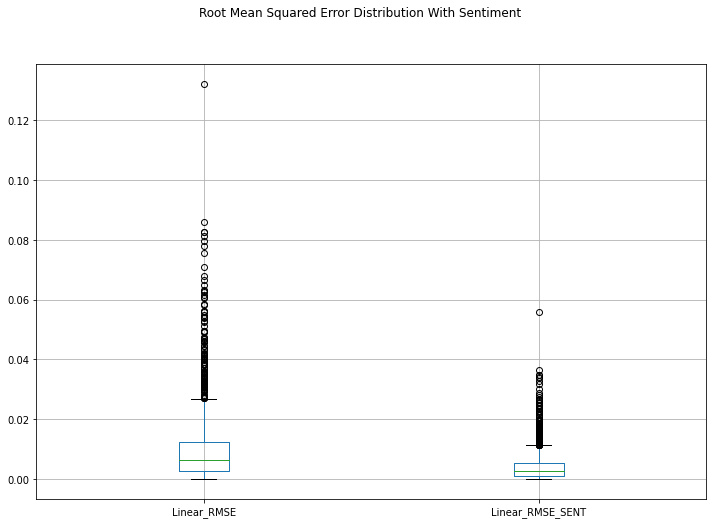

In [31]:
MSFT_linear = MSFT_linear.rename(columns={'rt_sq_er':'Linear_RMSE','rt_sq_er_sent':'Linear_RMSE_SENT' })
boxplot = MSFT_linear.boxplot(column=['Linear_RMSE', 'Linear_RMSE_SENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [32]:
MSFT_linear.to_csv('MSFT_linear_results.csv')
MSFT_linear = MSFT_linear.rename(columns={'rt_sq_er':'Linear_RMSE','rt_sq_er_sent':'Linear_RMSE_SENT' })
MSFT_linear_RMSE = MSFT_linear[['Linear_RMSE','Linear_RMSE_SENT']]


In [33]:
MSFT_linear_RMSE.describe()

,Linear_RMSE,Linear_RMSE_SENT
count,1763.000000,1763.000000
mean,0.009965,0.004195
std,0.011700,0.004927
min,0.000006,0.000009
25%,0.002857,0.001217
50%,0.006292,0.002694
75%,0.012474,0.005296
max,0.132144,0.055914


In [39]:
MSFT_linear_RMSE.to_csv('MSFT_LIN_RESULTS_COMMS.csv')